## Short recap
Last time:
- basic forecasting
    - classical forecasters
    - reduction to ML forecasting
- evaluation
- using trees might be problematic

Will learn:
- how to fix trees using skime pipelines
- feature engineering
- hyperparameter optimization
- architecture optimization

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

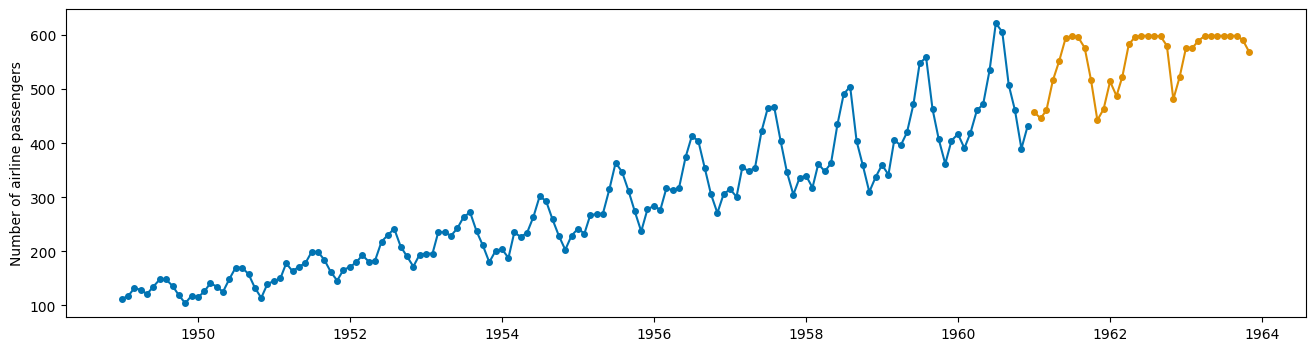

In [1]:
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.utils import plot_series

warnings.filterwarnings("ignore")

y = load_airline()
fh = np.arange(1, 36)

rf_forecaster = make_reduction(
    RandomForestRegressor(),
    window_length=12,
)

rf_forecaster.fit(y, fh=fh)

plot_series(y, rf_forecaster.predict())

⚠️ Warning: Decision trees (and ensembles) see targets in the range $[a, b]$ means they can only produce outputs in the range $[a, b]$ as well. **Impossible to capture trends!** Reason: in the leaves of the trees are only averages of targets, unless we use special trees like linear trees.

## Making tree-based models handle trends (the hard way)
We want to take the log and detrend the data, so the range of the targets is bounded, and a tree-based models can shine. The plan:

```mermaid
flowchart LR

A([y]) --> B[Log]
B --> C[Detrend]
C --> D{{Train}}
D --> E[Add Trend]
E --> F[Exp]
F --> G([y_pred])
```

Original data

<Axes: >

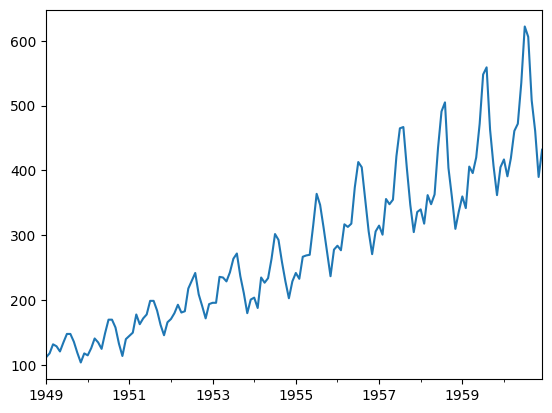

In [2]:
y.plot()

Logarithm to equalize the oszillations. Otherwise, same problem as before: even after detrending, the oszillations get larger and larger.

<Axes: >

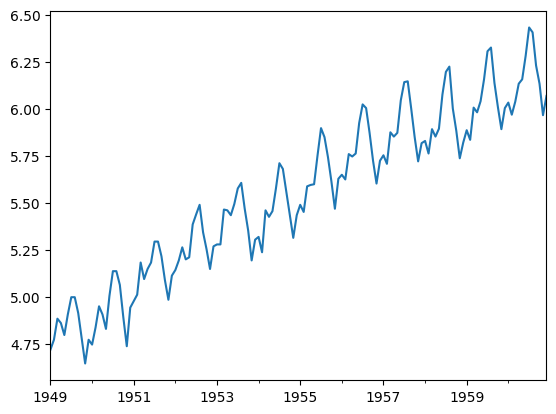

In [3]:
y_log = np.log(y)

y_log.plot()

Detrending brings the time series into a nice range.

<Axes: >

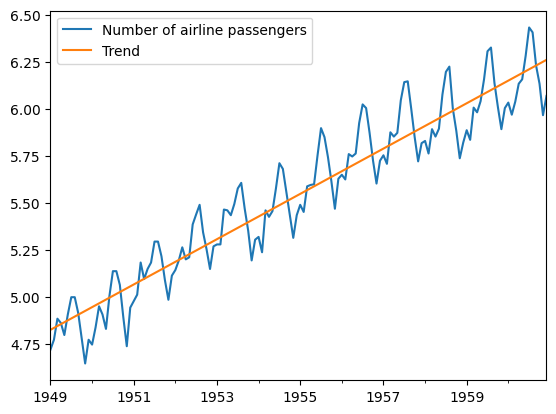

In [4]:
from sklearn.linear_model import LinearRegression

X = np.arange(len(y)).reshape(-1, 1)
lr = LinearRegression().fit(X, y_log)

y_log.to_frame().assign(Trend=lr.predict(X)).plot()

Much easier to learn.

<Axes: >

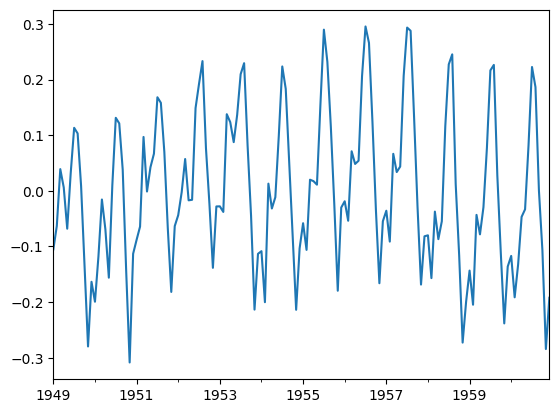

In [5]:
y_log_detrended = y_log - lr.predict(X)

y_log_detrended.plot()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

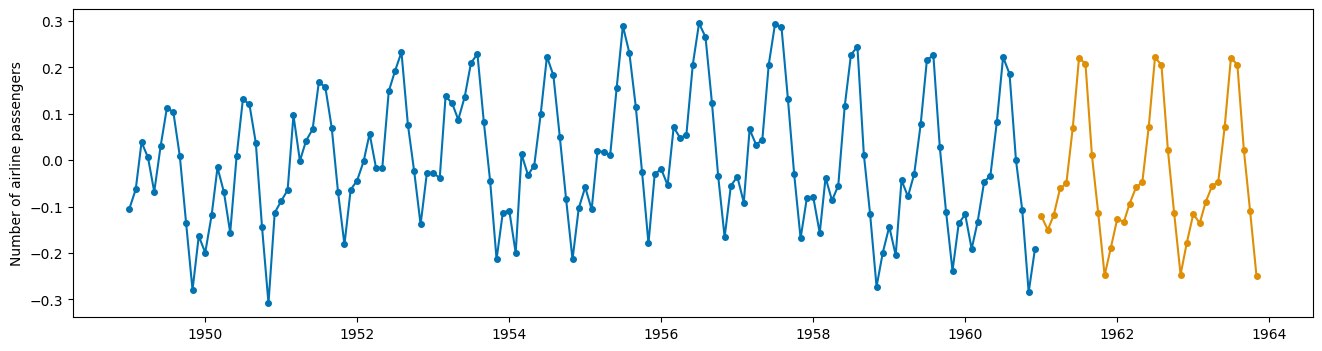

In [6]:
rf_forecaster = make_reduction(estimator=RandomForestRegressor(), window_length=12).fit(
    y_log_detrended, fh=fh
)

plot_series(y_log_detrended, rf_forecaster.predict())

### Add the trend back and exponentiate

In [7]:
X_extrapolate = np.arange(X.max() + 1, X.max() + 1 + fh.max()).reshape(-1, 1)

In [8]:
print("last trend values:", X[-5:])
print("forecasting trend values:", X_extrapolate[:5])

last trend values: [[139]
 [140]
 [141]
 [142]
 [143]]
forecasting trend values: [[144]
 [145]
 [146]
 [147]
 [148]]


In [9]:
y_pred_manual = rf_forecaster.predict()
y_pred_manual = y_pred_manual + lr.predict(X_extrapolate)
y_pred_manual = np.exp(y_pred_manual)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

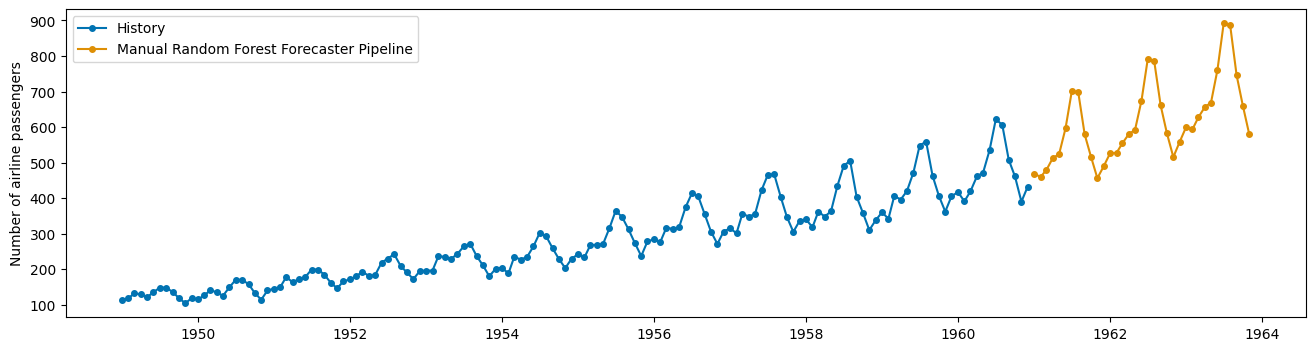

In [10]:
plot_series(y, y_pred_manual, labels=["History", "Manual Random Forest Forecaster Pipeline"])

*Cumbersome!* Especially when doing more transformations (e.g., imputing, deseasonalizing, differencing, ...).

⚠️ **Warning:** If done manually, you must pay attention that you don't leak any data. This could happen if you detrend first and *then* split the data. Let's check out a much easier and safer way.

## sktime pipelines
Put all the steps in one *pipeline*, like in scikit-learn. The best part: **sktime pipelines** also handle the **correct inverse transformations** in the **correct order**. 

Further advantages:
* no data leakage
* acts like one model (fit/predict)
  * store the entire model with a simple pipe.save()
* easy hyperparametertuning (see later!)

In [11]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Detrender

In [12]:
pipe = TransformedTargetForecaster(
    [
        ("log", LogTransformer()), # step 1
        ("detrend", Detrender()), # step 2
        (
            "forecast", # step 3
            make_reduction(estimator=RandomForestRegressor(), window_length=12),
        ),
    ],
)

In [13]:
pipe.fit(y, fh=fh)

TransformedTargetForecaster(steps=[('log', LogTransformer()),
                                   ('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                         window_length=12))])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

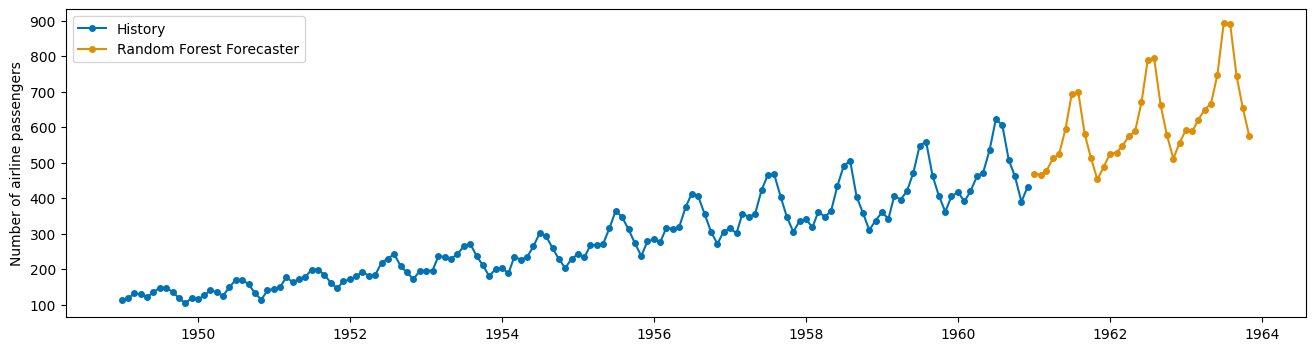

In [14]:
y_pred = pipe.predict()

plot_series(y, y_pred, labels=["History", "Random Forest Forecaster"])

Not necessary to store all steps manually.

In [15]:
pipe.save("log_detrend_rf_pipeline")

<zipfile.ZipFile filename='log_detrend_rf_pipeline.zip' mode='r'>

### Nice shortcut for (target transformer) pipelines: use *

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

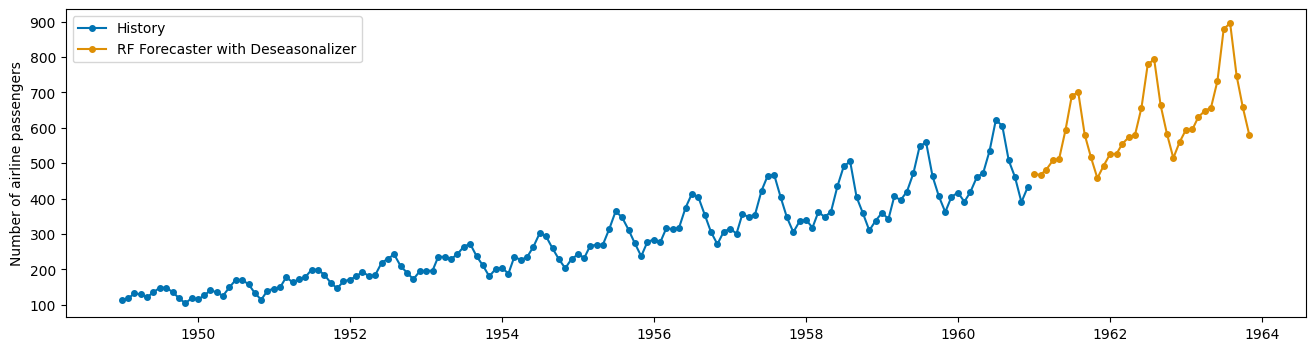

In [16]:
pipe_with_deseasonalizer = (
    LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

pipe_with_deseasonalizer.fit(y, fh=fh)

plot_series(
    y,
    pipe_with_deseasonalizer.predict(),
    labels=[
        "History",
        "RF Forecaster with Deseasonalizer",
    ],
)

### Imputation

<Axes: >

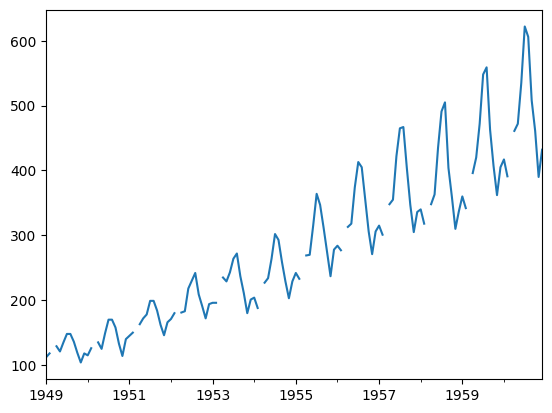

In [17]:
from sktime.transformations.series.impute import Imputer

y_with_nulls = y.copy()
y_with_nulls.iloc[range(2, len(y_with_nulls), 12)] = np.nan

y_with_nulls.plot()

Imputing is easy as well. There are many methods:
- forward fill
- backward fill
- linear interpolation
- many more

<Axes: >

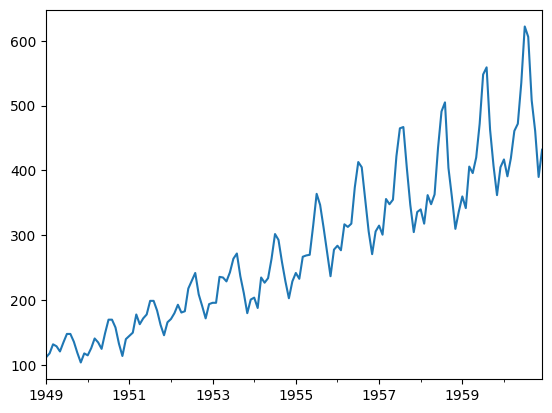

In [18]:
imp = Imputer(method="linear").fit(y)

imp.transform(y).plot()

In [19]:
pipe = (
    Imputer()
    * LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

pipe.fit(y, fh=fh)

TransformedTargetForecaster(steps=[Imputer(), LogTransformer(), Detrender(),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                        window_length=12)])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

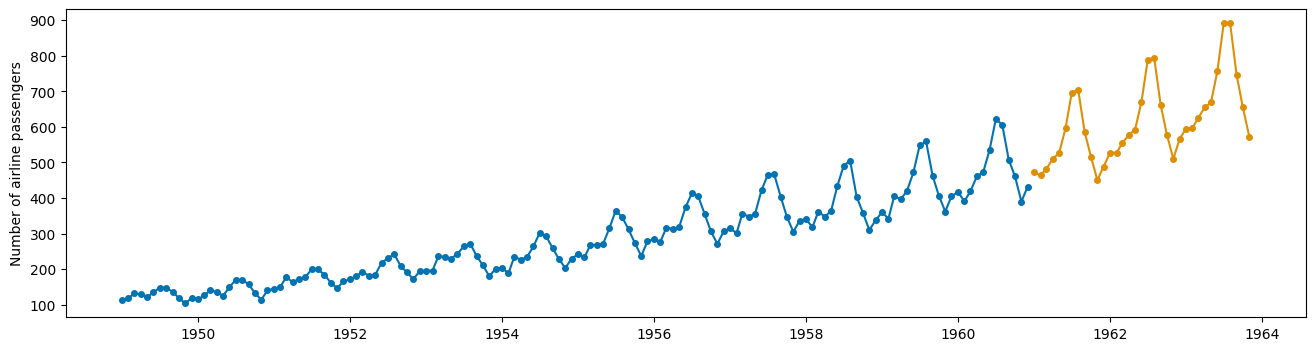

In [20]:
plot_series(y, pipe.predict())

### Seasonality

In [21]:
from sktime.transformations.series.detrend import Deseasonalizer


pipe = (
    Imputer()
    * Deseasonalizer(sp=12, model="multiplicative")
    * LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

pipe.fit(y, fh=fh)

TransformedTargetForecaster(steps=[Imputer(),
                                   Deseasonalizer(model='multiplicative',
                                                  sp=12),
                                   LogTransformer(), Detrender(),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                        window_length=12)])

<Axes: >

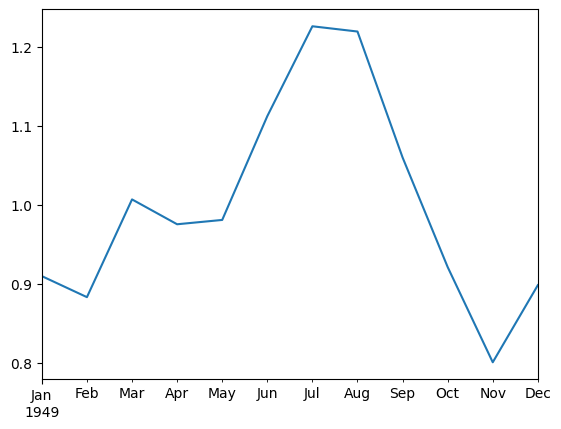

In [22]:
pipe.steps_[1][1].get_fitted_params()["seasonal"].plot()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

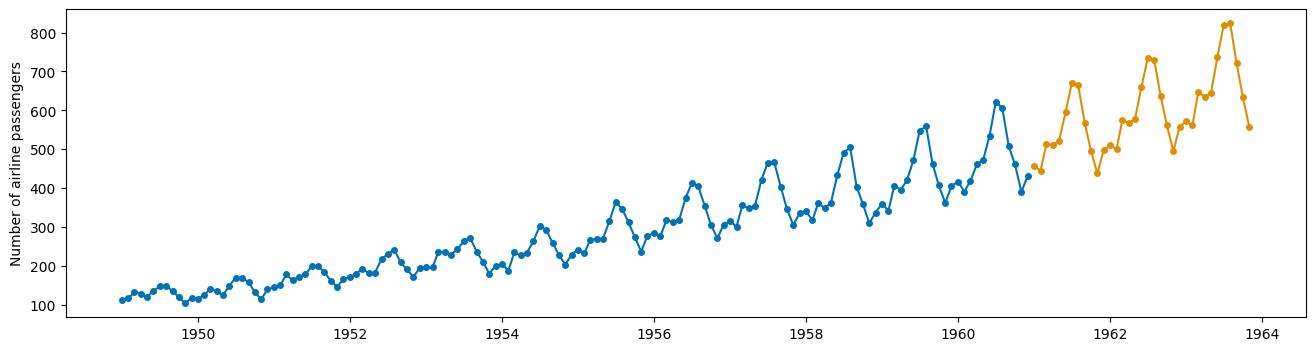

In [23]:
plot_series(y, pipe.predict())

## Feature engineering
Will derive simple time-related features:
* date features, e.g. weekday, month
* holidays

These are often good predictors, e.g. in retail:
* people prefer shopping on Saturdays
* people might shop more before certain holidays

In [24]:
from sktime.transformations.compose import Id
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.holiday import HolidayFeatures

Create example data with:
- weekly seasonality
- a peak at new year
- a (useless) exogenous variable

In [25]:
t = np.arange(90)

data = pd.DataFrame({
    "sales": 100 * np.sin(2*np.pi*t / 7) + 200 + 10 * np.random.randn(len(t)),
    "exo": np.random.randn(len(t)) + 10
}, index=pd.date_range("2024-01-01", periods=len(t)))

data.at["2024-01-01", "sales"] += 300

<Axes: >

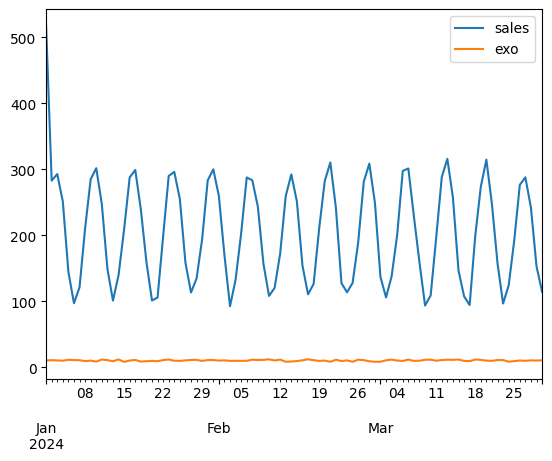

In [26]:
data.plot()

In [27]:
X = data.drop(columns="sales")
y = data["sales"]

In [28]:
X.head()

,exo
2024-01-01,10.240911
2024-01-02,10.549536
2024-01-03,10.246983
2024-01-04,9.807796
2024-01-05,11.124410


Also want to add day of week, month, and more.

In [29]:
DateTimeFeatures().fit_transform(X)

,year,month_of_year,day_of_week,hour_of_day,minute_of_hour,second_of_minute,millisecond_of_second
2024-01-01,2024,1,0,0,0,0,0
2024-01-02,2024,1,1,0,0,0,0
2024-01-03,2024,1,2,0,0,0,0
2024-01-04,2024,1,3,0,0,0,0
2024-01-05,2024,1,4,0,0,0,0
...,...,...,...,...,...,...,...
2024-03-26,2024,3,1,0,0,0,0
2024-03-27,2024,3,2,0,0,0,0
2024-03-28,2024,3,3,0,0,0,0
2024-03-29,2024,3,4,0,0,0,0


Also want holidays.

In [30]:
from holidays import US

calendar = US()

HolidayFeatures(calendar).fit_transform(X)

,Martin Luther King Jr. Day,New Year's Day,Washington's Birthday
2024-01-01,0,1,0
2024-01-02,0,0,0
2024-01-03,0,0,0
2024-01-04,0,0,0
2024-01-05,0,0,0
...,...,...,...
2024-03-26,0,0,0
2024-03-27,0,0,0
2024-03-28,0,0,0
2024-03-29,0,0,0


Have everything separate, but want to combine them into a single dataset. Use `FeatureUnion` or just `+`!

In [31]:
date_features = (
    Id()
    + DateTimeFeatures(manual_selection=["day_of_week", "month_of_year"])
    + HolidayFeatures(calendar=calendar)
)

date_features

FeatureUnion(transformer_list=[Id(),
                               DateTimeFeatures(manual_selection=['day_of_week',
                                                                  'month_of_year']),
                               HolidayFeatures(calendar={datetime.date(2024, 1, 1): 'New '
                                                                                    "Year's "
                                                                                    'Day',
                                                         datetime.date(2024, 1, 15): 'Martin '
                                                                                     'Luther '
                                                                                     'King '
                                                                                     'Jr. '
                                                                                     'Day',
                                                         datetime.date(2024, 2, 19): "Washington's "
                                                                                     'Birthday',
                                                         datetime.date(2024, 5, 27): 'Memorial '
                                                                                     'Day',
                                                         datetime.date(2024, 6, 19): 'Juneteenth '
                                                                                     'National '
                                                                                     'Independence '
                                                                                     'Day',
                                                         datetime.date(2024, 7, 4): 'Independence '
                                                                                    'Day',
                                                         datetime.date(2024, 9, 2): 'Labor '
                                                                                    'Day',
                                                         datetime.date(2024, 10, 14): 'Columbus '
                                                                                      'Day',
                                                         datetime.date(2024, 11, 11): 'Veterans '
                                                                                      'Day',
                                                         datetime.date(2024, 11, 28): 'Thanksgiving',
                                                         datetime.date(2024, 12, 25): 'Christmas '
                                                                                      'Day'})])

In [32]:
date_features.fit_transform(X)

,Id__exo,DateTimeFeatures__month_of_year,DateTimeFeatures__day_of_week,HolidayFeatures__Martin Luther King Jr. Day,HolidayFeatures__New Year's Day,HolidayFeatures__Washington's Birthday
2024-01-01,10.240911,1,0,0,1,0
2024-01-02,10.549536,1,1,0,0,0
2024-01-03,10.246983,1,2,0,0,0
2024-01-04,9.807796,1,3,0,0,0
2024-01-05,11.124410,1,4,0,0,0
...,...,...,...,...,...,...
2024-03-26,10.053325,3,1,0,0,0
2024-03-27,9.583649,3,2,0,0,0
2024-03-28,10.287431,3,3,0,0,0
2024-03-29,10.069653,3,4,0,0,0


In [33]:
from sktime.forecasting.compose import ForecastingPipeline


In [34]:
pipe = (
    Imputer()
    * LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=7)
)

exo_pipe = ForecastingPipeline([date_features, pipe])

# equivalent
exo_pipe = date_features**pipe

exo_pipe.fit(y=y, X=X, fh=fh)

ForecastingPipeline(steps=[FeatureUnion(transformer_list=[Id(),
                                                          DateTimeFeatures(manual_selection=['day_of_week',
                                                                                             'month_of_year']),
                                                          HolidayFeatures(calendar={datetime.date(2024, 1, 1): 'New '
                                                                                                               "Year's "
                                                                                                               'Day',
                                                                                    datetime.date(2024, 1, 15): 'Martin '
                                                                                                                'Luther '
                                                                                                                'King '
                                                                                                                'Jr. '
                                                                                                                'Day',
                                                                                    datetime.date(2024, 2, 19): "Washington's "
                                                                                                                'Birthday',
                                                                                    datetime.date(2024, 5, 27): 'Memorial '
                                                                                                                'Day',
                                                                                    da...
                                                                                    datetime.date(2024, 9, 2): 'Labor '
                                                                                                               'Day',
                                                                                    datetime.date(2024, 10, 14): 'Columbus '
                                                                                                                 'Day',
                                                                                    datetime.date(2024, 11, 11): 'Veterans '
                                                                                                                 'Day',
                                                                                    datetime.date(2024, 11, 28): 'Thanksgiving',
                                                                                    datetime.date(2024, 12, 25): 'Christmas '
                                                                                                                 'Day'})]),
                           TransformedTargetForecaster(steps=[Imputer(),
                                                              LogTransformer(),
                                                              Detrender(),
                                                              RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                                                   window_length=7)])])

💡 In the first part of `ForecastingPipeline` (left of `**`), `X` gets changed. In the second part `y`.

Again, everything is accessible.

In [35]:
fitted_model = exo_pipe.get_fitted_params()["TransformedTargetForecaster__RecursiveTabularRegressionForecaster__estimator"]
fitted_model

RandomForestRegressor()

### Window Summarizer
Lets you create lags and running statistics. Turns one time series into multiple.

In [36]:
from sktime.transformations.series.summarize import WindowSummarizer

In [37]:
y = load_airline()

X = pd.DataFrame({
    "exo": np.random.poisson(lam=5, size=len(y))
}, index=y.index)

window_summarizer_config = {
    "lag": [0, 1],
    "mean": [[1, 2], [2, 3]],
    "std": [[1, 2]],
}

window_summarizer = WindowSummarizer(
    lag_feature=window_summarizer_config, target_cols=["exo"]
)

<img src="imgs/window_summarizer.png" alt="placeholder" width="50%">

In [38]:
window_summarizer.fit_transform(X, y)

,exo_lag_0,exo_lag_1,exo_mean_1_2,exo_mean_2_3,exo_std_1_2
Period,,,,,
1949-01,3,NaN,NaN,NaN,NaN
1949-02,5,3.0,NaN,NaN,NaN
1949-03,3,5.0,4.0,NaN,1.414214
1949-04,6,3.0,4.0,NaN,1.414214
1949-05,2,6.0,4.5,3.666667,2.121320
...,...,...,...,...,...
1960-08,4,4.0,4.0,3.000000,0.000000
1960-09,7,4.0,4.0,3.333333,0.000000
1960-10,8,7.0,5.5,4.000000,2.121320


`WindowSummarizer` in action.

In [39]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

In [40]:
y = load_airline()

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=36)

arimax = (window_summarizer * Imputer()) ** ARIMA(order=(12, 1, 0))
arimax.fit(y=y_train, X=X_train, fh=np.arange(1, 37))

c:\Users\rober\Desktop\sktime\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ForecastingPipeline(steps=[WindowSummarizer(lag_feature={'lag': [0, 1],
                                                         'mean': [[1, 2],
                                                                  [2, 3]],
                                                         'std': [[1, 2]]},
                                            target_cols=['exo']),
                           Imputer(), ARIMA(order=(12, 1, 0))])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

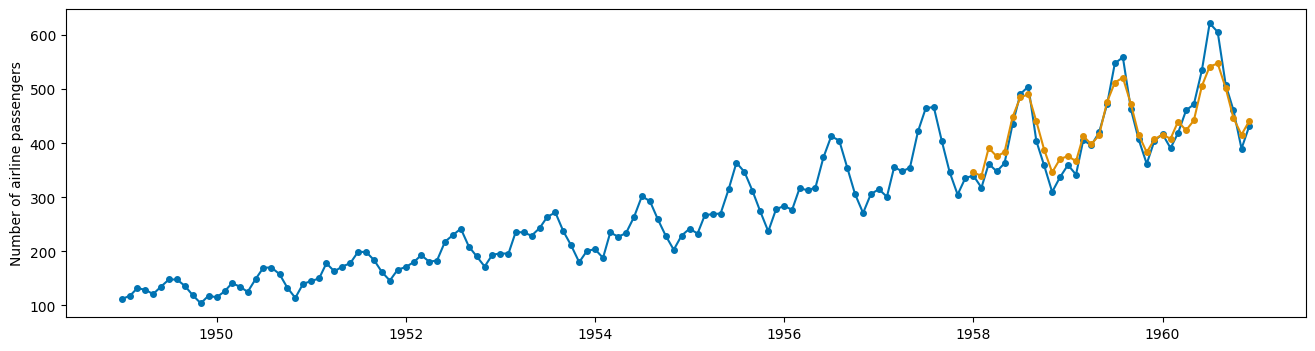

In [41]:
plot_series(y, arimax.predict(X=X_test))

In [42]:
arimax.forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:              SARIMAX(12, 1, 0)   Log Likelihood                -393.370
Date:                Sun, 23 Mar 2025   AIC                            824.741
Time:                        14:38:39   BIC                            875.525
Sample:                    01-31-1949   HQIC                           845.328
                         - 12-31-1957                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.0923      2.749      2.217      0.027       0.705      11.479
exo_lag_0       -0.5308      0.359     -1.476      0.140      -1.235       0.174
exo_lag_1        0.3292      0.517      0.637      0.524      -0.684       1.342
exo_mean_1_2    -1.6312      0.762     -2.142      0.032      -3.124      -0.138
exo_mean_2_3     1.8971      1.225      1.549      0.121      -0.504       4.298
exo_std_1_2     -0.1510      0.563     -0.268      0.789      -1.255       0.953
ar.L1           -0.1641      0.107     -1.529      0.126      -0.374       0.046
ar.L2           -0.2151      0.110     -1.962      0.050      -0.430      -0.000
ar.L3           -0.1485      0.090     -1.641      0.101      -0.326       0.029
ar.L4           -0.2536      0.103     -2.452      0.014      -0.456      -0.051
ar.L5           -0.1446      0.105     -1.380      0.168      -0.350       0.061
ar.L6           -0.2147      0.092     -2.341      0.019      -0.394      -0.035
ar.L7           -0.1678      0.118     -1.425      0.154      -0.399       0.063
ar.L8           -0.2387      0.104     -2.299      0.022      -0.442      -0.035
ar.L9           -0.1658      0.114     -1.453      0.146      -0.389       0.058
ar.L10          -0.2492      0.115     -2.165      0.030      -0.475      -0.024
ar.L11          -0.1220      0.128     -0.950      0.342      -0.374       0.130
ar.L12           0.6905      0.107      6.430      0.000       0.480       0.901
sigma2          85.9255     17.707      4.853      0.000      51.220     120.630
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.37   Prob(JB):                         0.34
Heteroskedasticity (H):               2.05   Skew:                             0.26
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Window Summarizer Together with make_reduction

In [43]:
forecaster = make_reduction(
    LinearRegression(),
    transformers=[WindowSummarizer(lag_feature={"lag": [1, 12]})],
    window_length=None,
    pooling="global",
)

In [44]:
forecaster.fit(y, fh=fh)

RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                     pooling='global',
                                     transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                         12]})],
                                     window_length=None)

Only two coefficients!

In [45]:
forecaster.estimator_.coef_

array([0.14151034, 0.9268337 ])

Great prediction using only lag 1 and 12.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

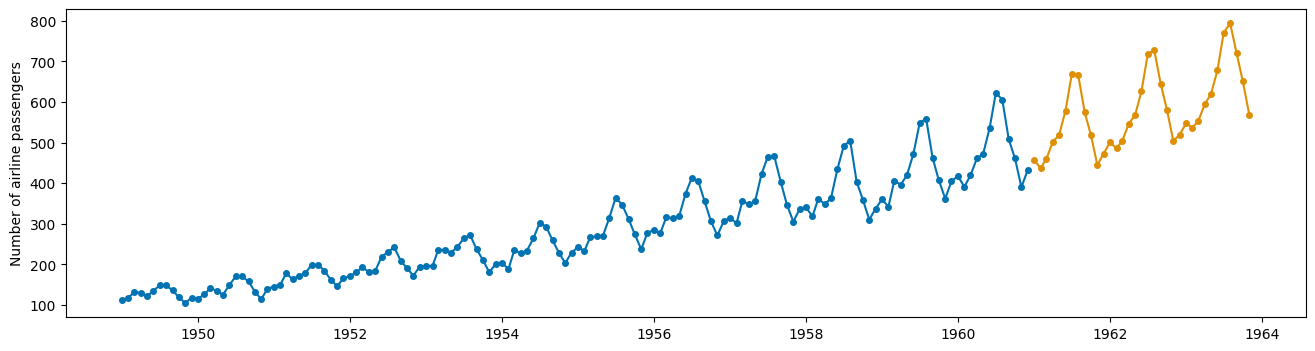

In [46]:
plot_series(y, forecaster.predict())

## Tuning
Lot of knobs to tune. E.g. in ETS:
- trend type: add, mult, none
  - damped: yes or no
- seasonality type: add, mult, none
- use Box-Cox: yes or no
- ...

Easy in sktime (similar to sklearn)!

In [47]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import ExpandingGreedySplitter
from sktime.utils.plotting import plot_windows

# also available: ForecastingRandomizedSearchCV, ForecastingOptunaSearchCV, ForecastingSkoptSearchCV

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

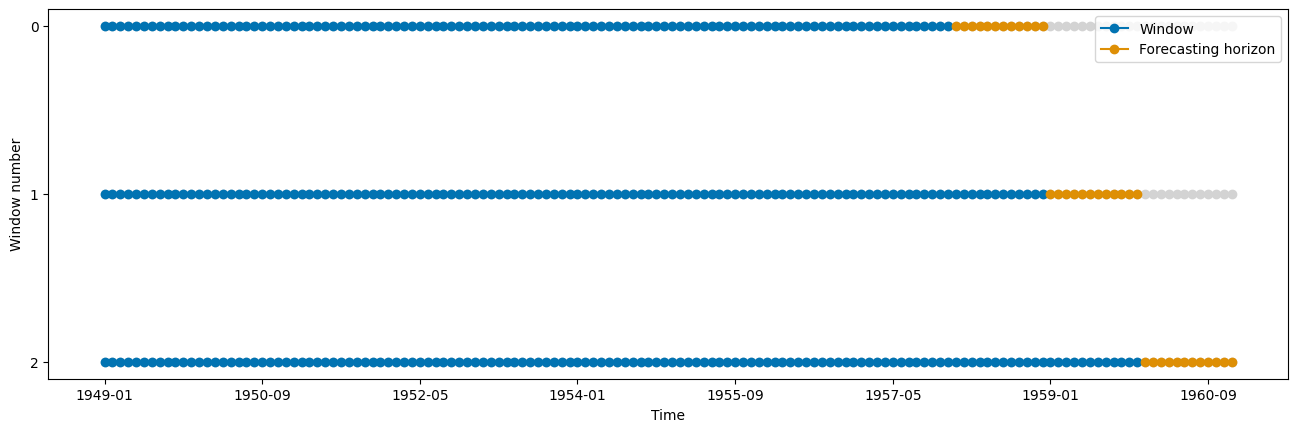

In [48]:
cv=ExpandingGreedySplitter(test_size=12, folds=3)

plot_windows(cv=cv, y=y)

Works like this:
1. select hyperparameters
2. train on blue, compute metric on orange
3. average the `folds` metrics you get
4. try different hyperparameters and go to 2.
5. pick the one with the best result from 3.

### Simple example

In [49]:
ets = ExponentialSmoothing()

Many things to tune!

In [50]:
ets.get_params()

{'damped_trend': False,
 'damping_trend': None,
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'method': None,
 'minimize_kwargs': None,
 'optimized': True,
 'random_state': None,
 'remove_bias': False,
 'seasonal': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'sp': None,
 'start_params': None,
 'trend': None,
 'use_boxcox': None,
 'use_brute': True}

In [51]:
grid_cv = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(seasonal="multiplicative"),
    param_grid={
        "trend": ["add", "mul"],
        "damped_trend": [True, False],
        "sp": [6, 12, 18],
    },
    cv=ExpandingGreedySplitter(test_size=12, folds=3),
)

In [52]:
grid_cv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=ExpandingGreedySplitter(folds=3, test_size=12),
                        forecaster=ExponentialSmoothing(seasonal='multiplicative'),
                        param_grid={'damped_trend': [True, False],
                                    'sp': [6, 12, 18],
                                    'trend': ['add', 'mul']})

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

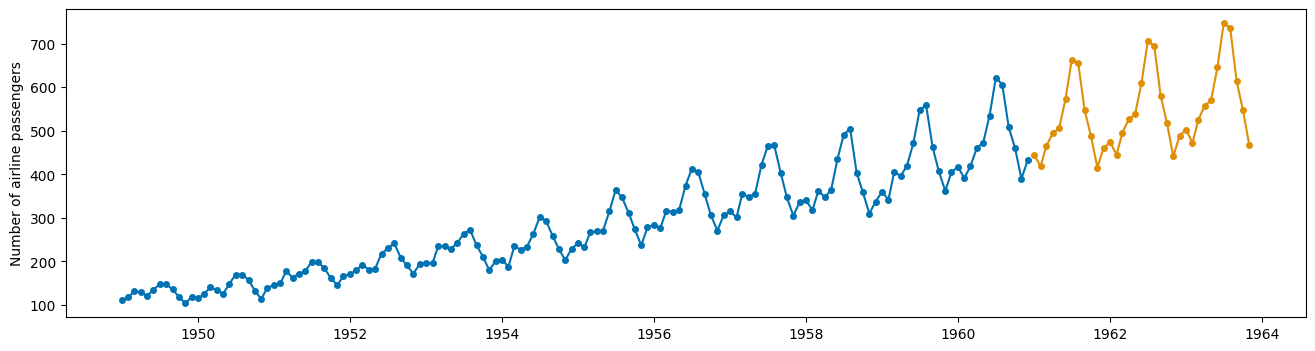

In [53]:
plot_series(y, grid_cv.predict())

Best parameters

In [54]:
grid_cv.best_params_

{'damped_trend': False, 'sp': 12, 'trend': 'add'}

Results for all combinations

In [55]:
grid_cv.cv_results_.sort_values("rank_test_MeanAbsolutePercentageError")

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
8,0.038603,0.498980,0.021960,"{'damped_trend': False, 'sp': 12, 'trend': 'add'}",1.0
2,0.043517,0.556566,0.027811,"{'damped_trend': True, 'sp': 12, 'trend': 'add'}",2.0
3,0.048633,0.820437,0.020731,"{'damped_trend': True, 'sp': 12, 'trend': 'mul'}",3.0
9,0.058637,0.591984,0.015709,"{'damped_trend': False, 'sp': 12, 'trend': 'mul'}",4.0
6,0.146428,0.333756,0.020910,"{'damped_trend': False, 'sp': 6, 'trend': 'add'}",5.0
7,0.151974,1.022255,0.021088,"{'damped_trend': False, 'sp': 6, 'trend': 'mul'}",6.0
0,0.157786,0.465611,0.021279,"{'damped_trend': True, 'sp': 6, 'trend': 'add'}",7.0
10,0.159805,0.397025,0.023653,"{'damped_trend': False, 'sp': 18, 'trend': 'add'}",8.0
1,0.160200,0.865038,0.028828,"{'damped_trend': True, 'sp': 6, 'trend': 'mul'}",9.0
11,0.162610,0.630860,0.038464,"{'damped_trend': False, 'sp': 18, 'trend': 'mul'}",10.0


### Complex pipeline

In [56]:
pipe = (
    LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

Get inspired with parameters

In [57]:
pipe.get_params()

{'steps': [LogTransformer(),
  Detrender(),
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                       window_length=12)],
 'LogTransformer': LogTransformer(),
 'Detrender': Detrender(),
 'RecursiveTabularRegressionForecaster': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                      window_length=12),
 'LogTransformer__offset': 0,
 'LogTransformer__scale': 1,
 'Detrender__forecaster': None,
 'Detrender__model': 'additive',
 'RecursiveTabularRegressionForecaster__estimator': RandomForestRegressor(),
 'RecursiveTabularRegressionForecaster__pooling': 'local',
 'RecursiveTabularRegressionForecaster__transformers': None,
 'RecursiveTabularRegressionForecaster__window_length': 12,
 'RecursiveTabularRegressionForecaster__estimator__bootstrap': True,
 'RecursiveTabularRegressionForecaster__estimator__ccp_alpha': 0.0,
 'RecursiveTabularRegressionForecaster__estimator__criterion': 'squared

In [58]:
grid_cv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid={
        "LogTransformer__offset": [0, 10],
        "Detrender__model": ["additive", "multiplicative"],
        "RecursiveTabularRegressionForecaster__window_length": [6, 12],
        "RecursiveTabularRegressionForecaster__estimator__max_depth": [5, 10],
    },
    cv=ExpandingGreedySplitter(test_size=12, folds=3),
)

In [59]:
grid_cv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=ExpandingGreedySplitter(folds=3, test_size=12),
                        forecaster=TransformedTargetForecaster(steps=[LogTransformer(),
                                                                      Detrender(),
                                                                      RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                                                           window_length=12)]),
                        param_grid={'Detrender__model': ['additive',
                                                         'multiplicative'],
                                    'LogTransformer__offset': [0, 10],
                                    'RecursiveTabularRegressionForecaster__estimator__max_depth': [5,
                                                                                                   10],
                                    'RecursiveTabularRegressionForecaster__window_length': [6,
                                                                                            12]})

In [60]:
grid_cv.best_params_

{'Detrender__model': 'additive',
 'LogTransformer__offset': 10,
 'RecursiveTabularRegressionForecaster__estimator__max_depth': 10,
 'RecursiveTabularRegressionForecaster__window_length': 12}

### Do we need the `LogTransformer`?

In [61]:
from sktime.transformations.compose import OptionalPassthrough

In [62]:
pipe_optional_log = (
    OptionalPassthrough(LogTransformer())
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

# shorter
pipe_optional_log = (
    -LogTransformer()
    * Detrender()
    * make_reduction(estimator=RandomForestRegressor(), window_length=12)
)

In [63]:
pipe_optional_log

TransformedTargetForecaster(steps=[OptionalPassthrough(transformer=LogTransformer()),
                                   Detrender(),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                        window_length=12)])

In [64]:
pipe_optional_log.get_params()

{'steps': [OptionalPassthrough(transformer=LogTransformer()),
  Detrender(),
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                       window_length=12)],
 'OptionalPassthrough': OptionalPassthrough(transformer=LogTransformer()),
 'Detrender': Detrender(),
 'RecursiveTabularRegressionForecaster': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                      window_length=12),
 'OptionalPassthrough__passthrough': False,
 'OptionalPassthrough__transformer': LogTransformer(),
 'OptionalPassthrough__transformer__offset': 0,
 'OptionalPassthrough__transformer__scale': 1,
 'Detrender__forecaster': None,
 'Detrender__model': 'additive',
 'RecursiveTabularRegressionForecaster__estimator': RandomForestRegressor(),
 'RecursiveTabularRegressionForecaster__pooling': 'local',
 'RecursiveTabularRegressionForecaster__transformers': None,
 'RecursiveTabularRegressionForecaster__window_length': 12,
 '

In [65]:
grid_cv = ForecastingGridSearchCV(
    forecaster=pipe_optional_log,
    param_grid={
        "OptionalPassthrough__passthrough": [True, False],
        "Detrender__model": ["additive", "multiplicative"],
        "RecursiveTabularRegressionForecaster__window_length": [6, 12],
        "RecursiveTabularRegressionForecaster__estimator__max_depth": [5, 10],
    },
    cv=ExpandingGreedySplitter(test_size=12, folds=3),
).fit(y)

In [66]:
grid_cv.best_params_

{'Detrender__model': 'additive',
 'OptionalPassthrough__passthrough': True,
 'RecursiveTabularRegressionForecaster__estimator__max_depth': 10,
 'RecursiveTabularRegressionForecaster__window_length': 12}

### AutoML: Which forecaster to choose?

In [67]:
from sktime.forecasting.compose import MultiplexForecaster

multiplex = MultiplexForecaster(
    forecasters=[
        (
            "rf",
            make_reduction(estimator=RandomForestRegressor(), window_length=12),
        ),
        (
            "ets",
            ExponentialSmoothing(trend="add")
        ),
    ],
)

automl = TransformedTargetForecaster(
    [
        ("log", LogTransformer()),
        ("detrend", Detrender()),
        ("forecast", multiplex),
    ],
)

# shorter
# automl = (
#     LogTransformer()
#     * Detrender()
#     * (make_reduction(estimator=RandomForestRegressor(), window_length=12) | ExponentialSmoothing(trend="add"))
# )

In [68]:
automl.get_params()

{'steps': [('log', LogTransformer()),
  ('detrend', Detrender()),
  ('forecast',
   MultiplexForecaster(forecasters=[('rf',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                          window_length=12)),
                                    ('ets', ExponentialSmoothing(trend='add'))]))],
 'log': LogTransformer(),
 'detrend': Detrender(),
 'forecast': MultiplexForecaster(forecasters=[('rf',
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                        window_length=12)),
                                  ('ets', ExponentialSmoothing(trend='add'))]),
 'log__offset': 0,
 'log__scale': 1,
 'detrend__forecaster': None,
 'detrend__model': 'additive',
 'forecast__forecasters': [('rf',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),

#### Bad variant
The following works, but is wasteful. If `selected_forecaster` is `ets`, there no use in trying different values for `rf__estimator__max_depth`. Iterates over $2*2*2*2*2 = 32$ combinations.

In [69]:
grid_cv = ForecastingGridSearchCV(
    forecaster=automl,
    param_grid={
        "forecast__selected_forecaster": ["ets", "rf"],
        "forecast__rf__window_length": [6, 12],
        "forecast__rf__estimator__max_depth": [5, 10],
        "forecast__ets__seasonal": ["add", "mul"],
        "forecast__ets__sp": [6, 12],
    },
    cv=ExpandingGreedySplitter(test_size=12, folds=3),
).fit(y, fh=fh)

In [70]:
grid_cv.best_params_

{'forecast__ets__seasonal': 'add',
 'forecast__ets__sp': 12,
 'forecast__rf__estimator__max_depth': 10,
 'forecast__rf__window_length': 12,
 'forecast__selected_forecaster': 'rf'}

In [71]:
grid_cv.cv_results_.sort_values("rank_test_MeanAbsolutePercentageError")

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
15,0.056890,1.082438,0.552540,"{'forecast__ets__seasonal': 'add', 'forecast__...",1.0
31,0.057289,0.553774,0.313709,"{'forecast__ets__seasonal': 'mul', 'forecast__...",2.0
3,0.057661,0.673137,0.437501,"{'forecast__ets__seasonal': 'add', 'forecast__...",3.0
7,0.057910,0.754750,0.431780,"{'forecast__ets__seasonal': 'add', 'forecast__...",4.0
27,0.058226,0.516655,0.420463,"{'forecast__ets__seasonal': 'mul', 'forecast__...",5.0
19,0.058460,0.548549,0.397475,"{'forecast__ets__seasonal': 'mul', 'forecast__...",6.0
23,0.058701,0.837518,0.472405,"{'forecast__ets__seasonal': 'mul', 'forecast__...",7.0
11,0.059345,0.537862,0.328156,"{'forecast__ets__seasonal': 'add', 'forecast__...",8.0
8,0.062715,0.355493,0.037620,"{'forecast__ets__seasonal': 'add', 'forecast__...",10.5
10,0.062715,0.352555,0.038453,"{'forecast__ets__seasonal': 'add', 'forecast__...",10.5


#### Better
Specify a **list of dictionaries**! Also works in sklearn. Iterataes over only $1*2*2 + 1*2*2 = 8$ combinations.

In [72]:
grid_cv = ForecastingGridSearchCV(
    forecaster=automl,
    param_grid=[
        {
            "forecast__selected_forecaster": ["rf"],
            "forecast__rf__window_length": [6, 12],
            "forecast__rf__estimator__max_depth": [5, 10],
        },
        {
            "forecast__selected_forecaster": ["ets"],
            "forecast__ets__seasonal": ["add", "mul"],
            "forecast__ets__sp": [6, 12],
        },
    ],
    cv=ExpandingGreedySplitter(test_size=12, folds=3),
).fit(y, fh=fh)

In [73]:
grid_cv.best_params_

{'forecast__rf__estimator__max_depth': 10,
 'forecast__rf__window_length': 12,
 'forecast__selected_forecaster': 'rf'}

In [74]:
grid_cv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.123878,0.454208,0.320154,"{'forecast__rf__estimator__max_depth': 5, 'for...",5.0
1,0.058415,0.479142,0.306916,"{'forecast__rf__estimator__max_depth': 5, 'for...",2.0
2,0.121144,0.468485,0.312247,"{'forecast__rf__estimator__max_depth': 10, 'fo...",4.0
3,0.057911,0.628745,0.260636,"{'forecast__rf__estimator__max_depth': 10, 'fo...",1.0
4,0.127342,0.475890,0.051229,"{'forecast__ets__seasonal': 'add', 'forecast__...",6.0
5,0.062715,0.430101,0.058047,"{'forecast__ets__seasonal': 'add', 'forecast__...",3.0
6,NaN,NaN,NaN,"{'forecast__ets__seasonal': 'mul', 'forecast__...",NaN
7,NaN,NaN,NaN,"{'forecast__ets__seasonal': 'mul', 'forecast__...",NaN


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

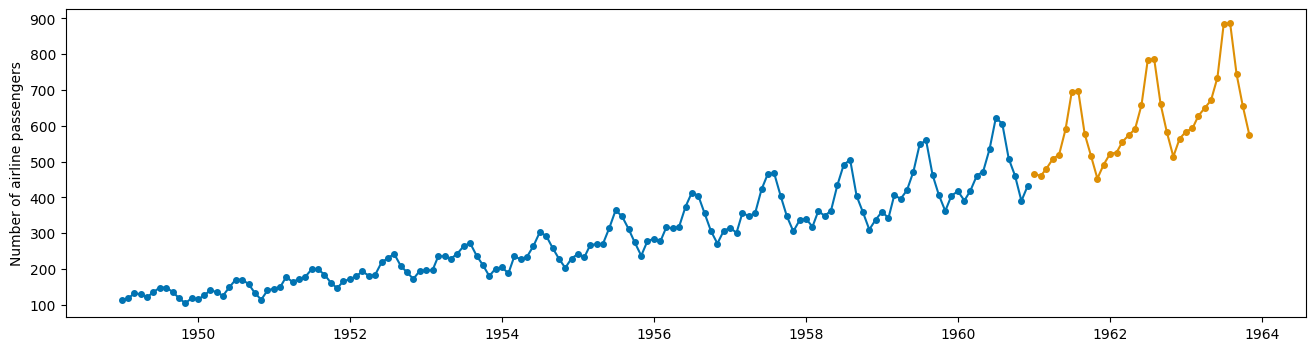

In [75]:
plot_series(y, grid_cv.predict())

## Nested cross-validation
Use case: you want to tune the hyperparameters to you model frequently and you want to access your **model pipeline's** performance

In [76]:
from sktime.forecasting.model_evaluation import evaluate

In [77]:
cv_results = evaluate(
    forecaster=grid_cv, y=y, X=None, cv=ExpandingGreedySplitter(test_size=12, folds=2)
)

In [78]:
cv_results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.065066,2.502930,0.016275,120,1958-12
1,0.036631,2.383722,0.106860,132,1959-12


Learned:
- how to fix trees using skime pipelines
- feature engineering
- hyperparameter optimization
- architecture optimization